In [2]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [121]:
%run dataset.py
%run config.py
%run __init__.py

In [47]:
train_dataset = PneumoniaDetectionDataset(split="train")

In [70]:
val_dataset = PneumoniaDetectionDataset(split="val")
test_dataset = PneumoniaDetectionDataset(split="test")

In [196]:
eval_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=True,
)

In [204]:
for data in eval_loader:
    break
list(data[1].numpy())

[1, 0]

In [31]:
item = None
for a in train_dataset:
    item = a
    break

In [32]:
image, label, original_image = item

In [33]:
image.shape

torch.Size([3, 224, 224])

In [34]:
label

0

In [55]:
def show(tensor, label):
    # Create figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Display the image
    ax.imshow(tensor.permute(1, 2, 0))
    ax.set_title(classes[label])

In [59]:
classes = train_dataset.dataset.classes

In [62]:
# show(train_dataset[0][0], train_dataset[0][1])
# show(train_dataset[4000][0], train_dataset[4000][1])

In [49]:
def show_images(dataset):
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    classes = dataset.classes
    for i in range(3):
        for j in range(3):
            image, label, _ = dataset[3 * i + j]
 
            axes[i, j].imshow(image.permute(1, 2, 0))
            axes[i, j].set_title(classes[label])
            axes[i, j].axis('off')
    
    plt.show()

In [51]:
# show_images(train_dataset)

<Axes: xlabel='count'>

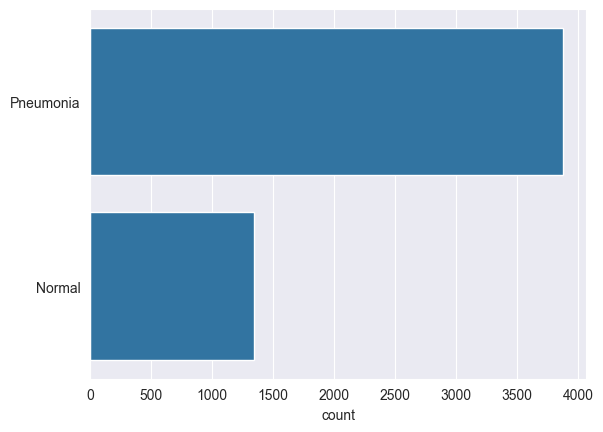

In [53]:
train_labels = []
for data in train_dataset:
    if(data[1] == 0):
        train_labels.append("Pneumonia")
    else:
        train_labels.append("Normal")
sns.set_style('darkgrid')
sns.countplot(train_labels)    

In [74]:
def show_classes(dataset):
    labels = []
    for data in dataset:
        if(data[1] == 0):
            labels.append("Pneumonia")
        else:
            labels.append("Normal")
    sns.set_style('darkgrid')
    sns.countplot(labels)    

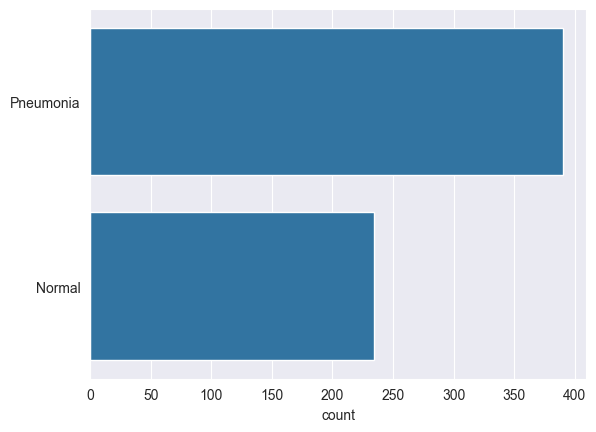

In [75]:
show_classes(test_dataset)

In [76]:
targets = torch.tensor([s[1] for s in test_dataset])
class_count = torch.tensor([(targets == i).sum() for i in [0, 1]])

In [77]:
class_count

tensor([390, 234])

In [78]:
weights = 1.0 / torch.tensor(
    [class_count[t] for t in targets], dtype=torch.float
)

In [80]:
from torch.utils.data import DataLoader, WeightedRandomSampler

In [81]:
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [82]:
sampler

In [83]:
from torchvision.models import resnet50, ResNet50_Weights

In [84]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.requires_grad_(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [89]:
model.avgpool = nn.Identity()  # type: ignore
model.fc = nn.Identity()  # type: ignore


In [90]:
output = model(image.unsqueeze(0))

In [91]:
output.shape

torch.Size([1, 100352])

In [92]:
image.shape

torch.Size([3, 224, 224])

In [94]:
image1 = torch.zeros([3, 448, 448])

In [95]:
output1 = model(image1.unsqueeze(0))

In [96]:
output1.shape

torch.Size([1, 401408])

In [97]:
a = torch.zeros([3 * 7 * 7])

In [99]:
b = torch.reshape(a, (-1, 3, 7, 7))

In [101]:
b.shape

torch.Size([1, 3, 7, 7])

In [122]:
model = DetectionModel()

In [126]:
output = model(image.unsqueeze(0))

In [127]:
output.shape

torch.Size([1, 1])

In [118]:
from torch import nn

In [128]:
output

tensor([[0.0172]], grad_fn=<AddmmBackward0>)

In [120]:
nn.Sigmoid()(output)

tensor([[0.4944]], grad_fn=<SigmoidBackward0>)

In [129]:
target = torch.empty(3, dtype=torch.long).random_(5)

In [130]:
target

tensor([2, 4, 3])

In [188]:
from torcheval.metrics import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

# For multiclass classification
accuracy_metric = MulticlassAccuracy(num_classes=2, average="micro")
precision_metric = MulticlassPrecision(num_classes=2, average=None)
recall_metric = MulticlassRecall(num_classes=2, average=None)
f1_metric = MulticlassF1Score(num_classes=2, average=None)

In [189]:
# accuracy_metric.update(torch.tensor([0, 0]), torch.tensor([1, 0]))
accuracy_metric.update(torch.tensor([0, 1, 1, 0]), torch.tensor([1, 0, 0, 0]))
precision_metric.update(torch.tensor([0, 1, 1, 0]), torch.tensor([1, 0, 0, 0]))
recall_metric.update(torch.tensor([0, 1, 1, 0]), torch.tensor([1, 0, 0, 0]))
f1_metric.update(torch.tensor([0, 1, 1, 0]), torch.tensor([1, 0, 0, 0]))

In [190]:
accuracy = accuracy_metric.compute()
precision = precision_metric.compute()
recall = recall_metric.compute()
f1 = f1_metric.compute()

In [191]:
accuracy, precision, recall, f1

(tensor(0.2500),
 tensor([0.5000, 0.0000]),
 tensor([0.3333, 0.0000]),
 tensor([0.4000, 0.0000]))

In [169]:
output.item()

0.5

In [170]:
pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [195]:
metric = MulticlassPrecision(num_classes=2, average=None)
input = torch.tensor([0])
target = torch.tensor([0])
metric.update(input, target)
metric.compute()

tensor([1., 0.])

In [205]:
len(train_dataset)

5216

In [208]:
import os
curr_best_path = "trained/epoch_0/"
os.makedirs(os.path.dirname(curr_best_path), exist_ok=True)

In [209]:
pretrained_path = "trained/epoch_1/"

In [210]:
model = torch.load(f"{pretrained_path}model.pth", weights_only=False)

In [211]:
model.eval()

In [214]:
output = model(image.unsqueeze(0))

In [216]:
torch.argmax(output, dim=1)

tensor([0])

In [218]:
torch.tensor(1).item()

1

In [221]:
import yaml

In [219]:
config_path = "experiments/configs/adam-1e4-64.yaml"

In [250]:
with open(config_path, "r") as f:
        config = yaml.safe_load(f)

In [251]:
config

{'batch_size': 64,
 'epochs': 10,
 'learning_rate': '1e-4',
 'optimizer_name': 'Adam',
 'augment': True,
 'max_samples': 8}

In [225]:
optimizer_class = getattr(torch.optim, "Adam")

In [226]:
optimizer = optimizer_class([], lr=1e-4)

ValueError: optimizer got an empty parameter list

In [227]:
optimizer_class

torch.optim.adam.Adam

In [228]:
optimizer_class = torch.optim.Adam

In [229]:
optimizer_class

torch.optim.adam.Adam

In [256]:
def f(
    epochs=1,
    batch_size=32,
    learning_rate=0.001,
    save_epochs=1,
    save_base_folder="trained/",
    **kwargs
):
    print(batch_size, learning_rate)
    print(kwargs)

In [257]:
f(**config)

64 1e-4
{'optimizer_name': 'Adam', 'augment': True, 'max_samples': 8}
